In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cp

In [2]:
def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [times[ind] - times[0] for ind, t in enumerate(times)]
    else:
        times = [i for i in range(len(xhistory))]
    return times, values

In [3]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 25,
          "xtick.labelsize": 15,
          "ytick.labelsize": 15,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

## Субградиент и субдифференциал

**Определение.** Вектор $g$ называется *субградиентом* функции $f$ в точке $x$, если $\forall y\in X$ выполнено

$$
f(y) \geq f(x) + \langle g, y - x \rangle \quad \quad (1)
$$

**Определение.** Множество всех субградиентов $f$ в точке $x$ будем называть *субдифференциалом* и будем обозначать как $\partial f(x)$.

### Основные свойства субдифференциала

- $\partial f(x)$ - замкнутое и выпуклое множество даже если $f$ не выпукло
- Если $f$ - выпуклая функция, то субдифференциал непуст и ограничен
- Если $f$ выпукла и дифференцируема в точке $x$, то $\partial f(x) = \{ \nabla f(x) \}$
- Точка $x^*$ является минимумом функции $f$ тогда и только тогда, когда $0 \in \partial f(x^*)$. В случае дифференцируемой, выпуклой $f$ это свойство сводится к $\nabla f(x^*) = 0$
- Если $f$ выпукла, то для производной по направлению выполняетя равенство $f'(x;v) = \sum_{g \in \partial f(x)} g^\top v$, где $v$ - вектор вдоль которого берется производная
- Точка $x^*$ является минимумом функции $f$ на выпуклом множестве $x^* \in X$ тогда и только тогда, когда $g^\top(y - x^*) \geq 0$ для всех $y \in X$ и $g \in \partial f(x^*)$

### Субдифференциальное исчисление
1) $\partial f(\alpha x) = \alpha \partial f(x)$, где $\alpha \geq 0$
2) $\partial f(x) = \partial \sum_i f_i(x) = \sum_i \partial f_i(x)$
3) Если $f$ - выпукла и $h(x) = f(Ax + b)$, то $\partial h(x) = A^\top \partial f(Ax + b)$
4) Если $f_i$ - выпуклы и $f(x) = \max_{i = i..m} f_i(x)$, то $\partial f(x) = Co \cup \{ \partial f_i(x) \ | \ f_i(x) = f(x) \}$
5) Если $F(x, y)$ субдифференцируема и выпукла по совокупности переменных, то $\partial f(x) = \partial ( \inf_y F(x, y) )$, где $x \in \mathbb{R}^n, y \in \mathbb{R}^m$, то $\partial f(x) = \{ g \in \mathbb{R}^n | (g, 0) \in \partial F(x, y_{\min}) \}$

### Пример 1. $l_1$ норма

Рассмотрим задачу
$$
f(x) = \| x \|_1 = |x_1| + ... + |x_n|
$$

Представим в виде
$$
\| x \|_1 = \max \{ s^\top x \ | \ s_i \in \{ -1, 1\} \}
$$

Тогда 
$$
g_{i}=\left\{\begin{array}{ll}
+1 & x_{i}>0\\
-1 & x_{i}<0\\
-1 \text{ или } +1 & x_{i}=0.
\end{array}\right.
$$

Субдифференциал - это выпуклая оболочка всех субградиентов, которые могут быть получены таким образом:

$$
\partial f(x)=\{g\ |\ \|g\|_{\infty}\leq 1,g^{T}x=\|x\|_{1}\}.
$$

### Пример 2. Максимальное собственное число суммы симметричныйх матриц.
Рассмотрим задачу
$$
\min_{x \in \mathbb{R}^n} \lambda_{\text{max}}(A(x)),
$$
где $A(x) = A_0 + x_1 A_1 + x_2 A_2 + ... + x_n A_n$ и $A_i \in S^m$.

Чтобы найти субградиент, преобразуем задачу к виду:
$$
f(x) = \lambda_{\text{max}}(A(x)) = \text{sup}_{\| y \|_2 = 1} y^\top A(x) y,
$$

Тогда для каждого $x$ и фиксированного $y$ субградиент нашей функции равен:
$\nabla f_y (x) = (y^\top A_1 y, ..., y^\top A_n y)$

Подробности см. https://web.stanford.edu/class/ee364b/lectures/subgradients_notes.pdf c.8

## Субградиентный метод

Мы решаем задачу оптимизации

$$\min_{\mathbf{x}\in\mathbb{R}^n} f(\mathbf{x})$$

Итерация субградиентного метода:

$$\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \mathbf{g}_k,$$

где $\mathbf{g}_k$ - субградиент $f$ в точке $\mathbf{x}_k$, $\alpha_k$ - длина шага.

Особенность алгоритма:  

- Направление субградиента $- \partial f(x)$ не всегда является направление убывания фукнции, пример: $f(x) = |x_1 - x_2| + 0.2 |x_1 + x_2|$ в точке $\{1, 1\}$ в (см. Б.Т. Поляк "Введение в оптимизацию" с. 128)
- С постоянной длиной шага метод может не сходиться
- Медленная скорость сходимости. Но есть способы ускорить: проксимальный метод, ускоренный субградиентный метод, шаг Поляка

Варианты подбора шага:

* Убывающий шаг: 
    $$
    \alpha_k = \frac{\| x_0 - x^* \|}{\sqrt{k+1}}
    $$ 
    оптимален для субградиентного метода (см. Ю.Е. Нестеров "Выпуклая оптимизация" с. 177)

<!-- * $\alpha_k = \frac{\alpha_0}{k+1}$ 
* $\alpha_k = \frac{\alpha_0}{k \ln {k}}$ 
* $\alpha_k = \frac{\alpha_0}{k^\rho}$, где $\rho \in (0, 1]$ -->

* Шаг Поляка: 
$$
\alpha_k=\frac{f_k-f^*}{\|g_k\|^2}
$$
, где $f^*$ - это решение. Когда оно может быть известно? При решении СЛАУ, для многих геометрических задач. Оптимален для субградиентного метода.

* Нормированный шаг: 
$$\alpha_k=\frac{\varepsilon}{\|g_k\|^2}$$
, где $\varepsilon$ невязка фукнции.

Условия остановки:
- $\| x_{k+1} -  x_k \| \leq \epsilon$

В качестве решения теперь берём либо **среднее** от k последних итераций либо **наименьшее** из всех итераций значение.

Условия остановки, которые НЕ подходят:
- $\| \partial f(x) \| \leq \epsilon$
- $\| f(x_{k+1}) -  f(x_k) \| \leq \epsilon$

## Реализация субградиентного метода

In [4]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []

    def solve(self, x0, f, gradf, tol=1e-3, max_iter=5000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or np.linalg.norm(x - x_prev) > tol:
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

Шаги

In [5]:
class StepSize:
    def __call__(self, x, h, k, *args, **kwargs):
        pass

# Убывающий шаг
class SeqStepSize(StepSize):
    def __init__(self, d=1, alpha0=1, alpha_function=None):
        if alpha_function is not None:
            self.alpha_function = alpha_function
        else:
            self.alpha_function = lambda k: alpha0/(k+1)**d
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha_function(k)

# Нормированный шаг
class ScaledConstantStepSize(StepSize):
    def __init__(self, alpha0=0.5):
        self.alpha0 = alpha0

    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return self.alpha0 / np.linalg.norm(gradf(x))**2
    
# шаг Поляка
class PolyakStepSize(StepSize):
    def __init__(self, f_sol=0.0):
        self.f_sol = f_sol

    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return (f(x) - self.f_sol) / np.linalg.norm(gradf(x)) ** 2

## Эксперимент 1. Решение СЛАУ

$$f(x) = \| Ax - b \|_1$$

Для нахождения субградиента применяем правило 3 и Пример 1:
$$
\partial f(x) = \partial ( \| Ax - b \|_1 ) = \text{sign} (|Ax - b|) \partial (Ax - b) = A^\top (\text{sign} (Ax - b))
$$

In [6]:
def func_SLE_l1(A, b):
    return lambda x: np.abs(A.dot(x) - b).sum()

def subgrad_func_SLE_l1(A, b):
    return lambda x: A.T @ np.sign(A.dot(x) - b)

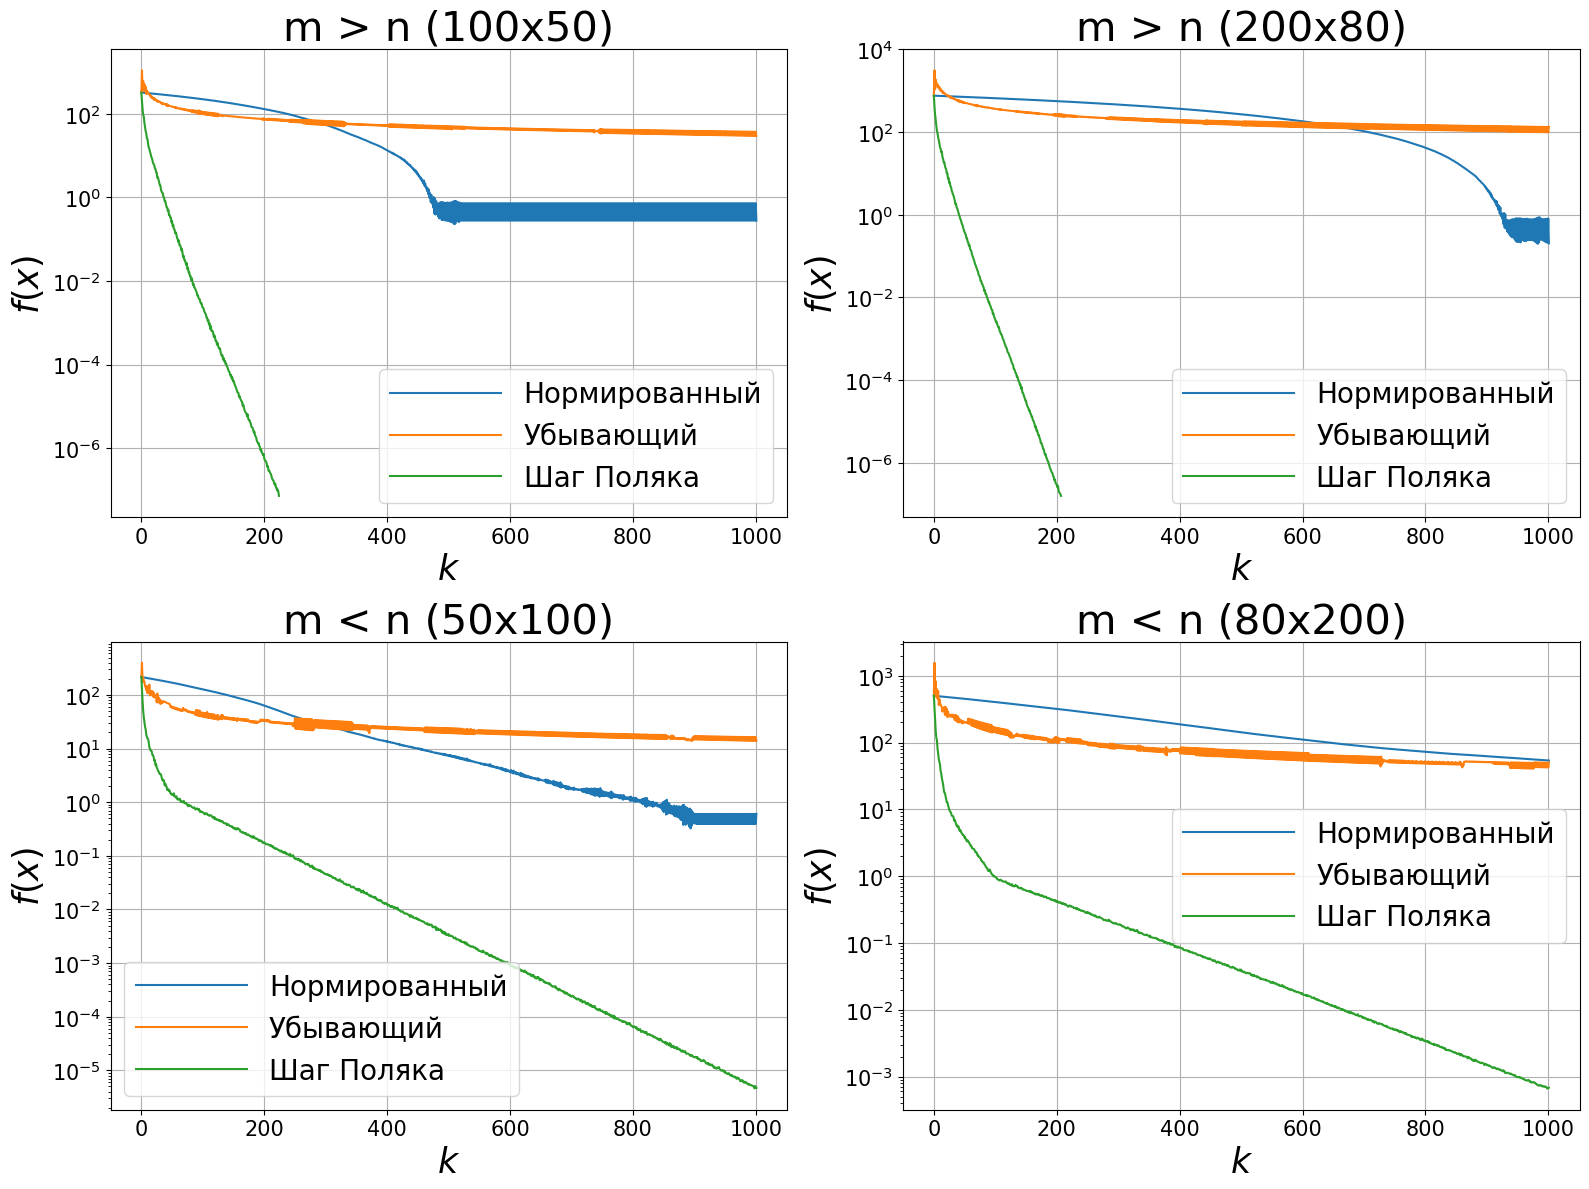

In [7]:
%matplotlib inline
np.random.seed(42)

configs = [
    {"m": 100, "n": 50, "title": "m > n (100x50)"},
    {"m": 200, "n": 80, "title": "m > n (200x80)"},
    {"m": 50, "n": 100, "title": "m < n (50x100)"},
    {"m": 80, "n": 200, "title": "m < n (80x200)"},
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, config in enumerate(configs):
    m, n = config["m"], config["n"]
    title = config["title"]

    A = np.random.randn(m, n)
    x_true = np.random.rand(n)
    b = A.dot(x_true)
    x0 = np.zeros(n)
    f_l1 = func_SLE_l1(A, b)
    subgradf_l1 = subgrad_func_SLE_l1(A, b)
    epsilon = 1e-9

    methods = [
        GradientDescent(ScaledConstantStepSize(1), name="Нормированный"),
        GradientDescent(SeqStepSize(d=0.5, alpha0=0.1), name="Убывающий"),
        GradientDescent(PolyakStepSize(f_sol=np.abs(A.dot(x_true) - b).sum()), name="Шаг Поляка"),
    ]

    for method in methods:
        method.history = []
        method.solve(x0, f_l1, subgradf_l1, tol=epsilon, max_iter=1000)

    ax = axes[idx]
    funcx = lambda x: f_l1(x)
    for method in methods:
        xhistory = method.history
        if not xhistory: continue
        iters, values = parse_logs(xhistory, ret_time=False, funcx=funcx)
        ax.semilogy(iters, values, label=method.name, linewidth=1.5)

    ax.grid()
    ax.set_ylabel(r"$f(x)$")
    ax.set_xlabel(r"$k$")
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

## $l_2$ решение

$$\min_x f(x) = \|Ax-b\|_2^2$$

Сравним близость к решению и скорость сходимости для гладкой и негладкой функции

In [8]:
def func_l2(A, b):
    return lambda x: np.linalg.norm(A.dot(x) - b)**2

def grad_f_l2(A, b):
    return lambda x: 2 * A.T.dot(A.dot(x) - b)

class ConstantStepSize(StepSize):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha

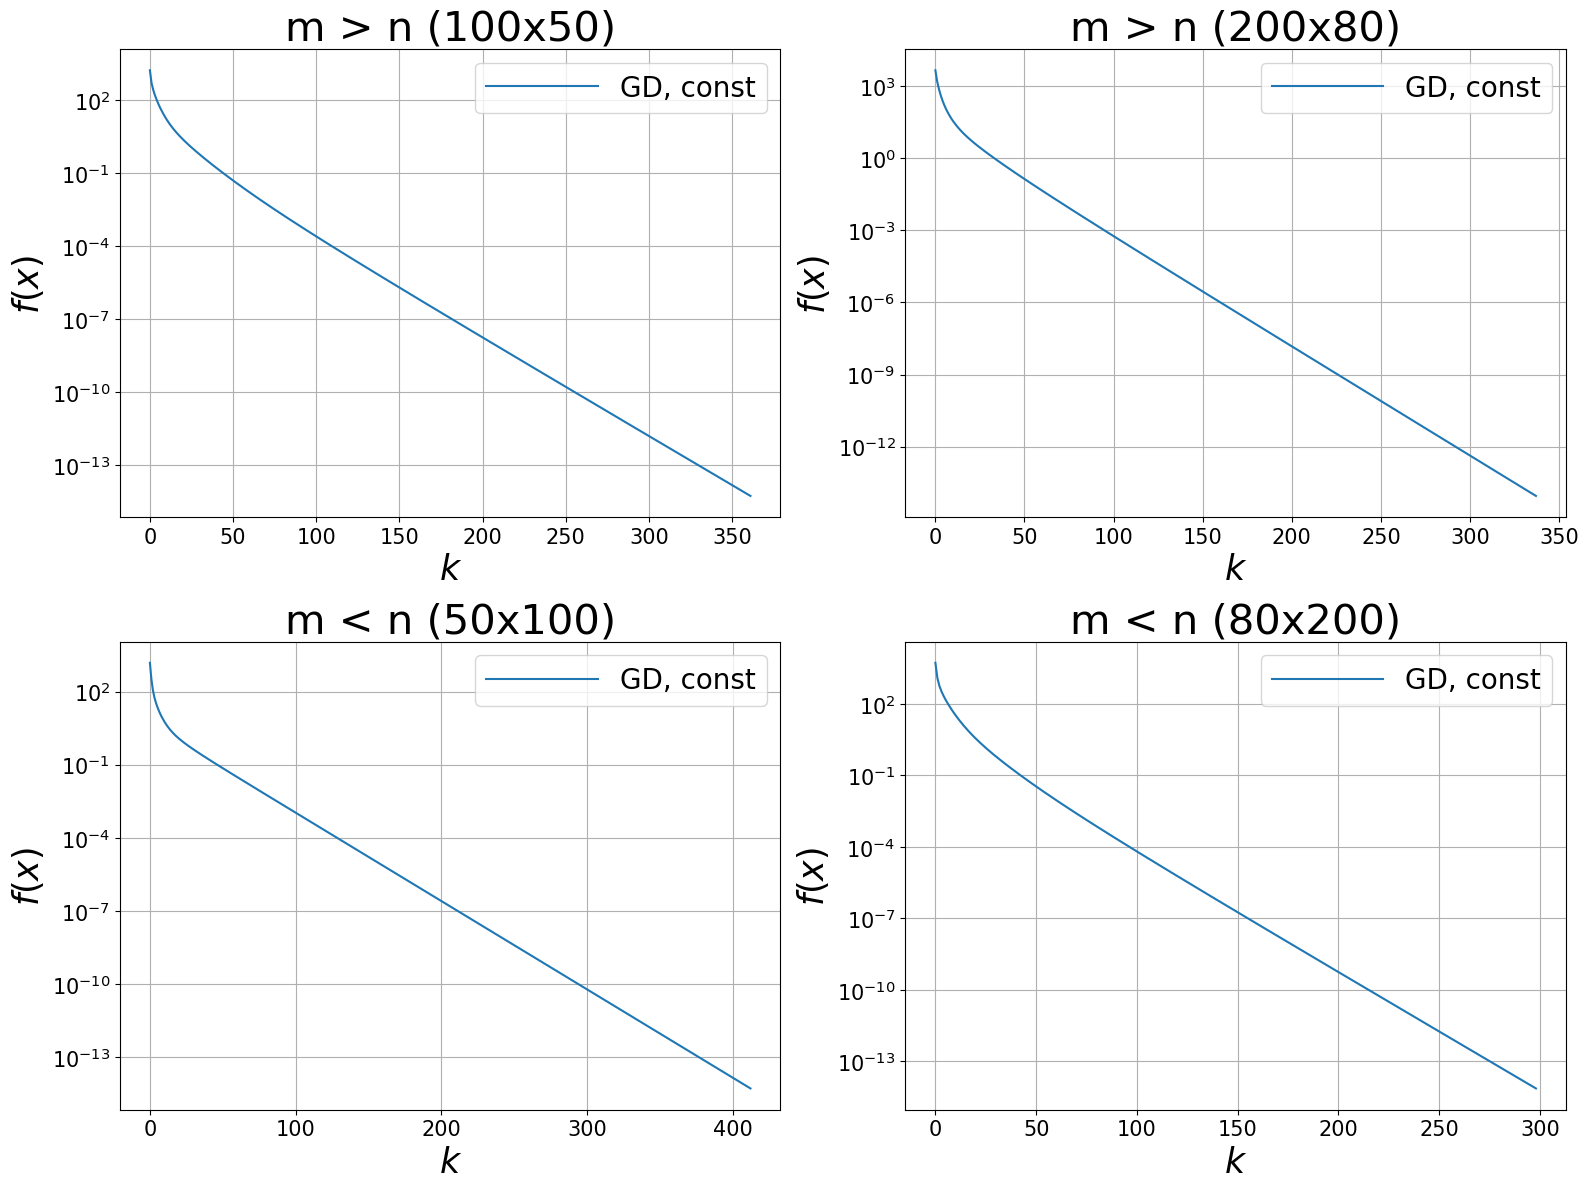

In [9]:
%matplotlib inline
np.random.seed(42)

configs = [
    {"m": 100, "n": 50, "title": "m > n (100x50)"},
    {"m": 200, "n": 80, "title": "m > n (200x80)"},
    {"m": 50, "n": 100, "title": "m < n (50x100)"},
    {"m": 80, "n": 200, "title": "m < n (80x200)"},
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, config in enumerate(configs):
    m, n = config["m"], config["n"]
    title = config["title"]

    A = np.random.randn(m, n)
    x_true = np.random.rand(n)
    b = A.dot(x_true)
    x0 = np.zeros(n)
    f_l2 = func_l2(A, b)
    gradf_l2 = grad_f_l2(A, b)
    L = 2 * np.linalg.norm(A, ord=2) ** 2
    epsilon = 1e-9

    methods = [GradientDescent(ConstantStepSize(1 / L), name="GD, const")]

    for method in methods:
        method.history = []
        method.solve(x0, f_l2, gradf_l2, tol=epsilon, max_iter=1000)

    ax = axes[idx]
    funcx = lambda x: f_l2(x)
    for method in methods:
        xhistory = method.history
        if not xhistory: continue
        iters, values = parse_logs(xhistory, ret_time=False, funcx=funcx)
        ax.semilogy(iters, values, label=method.name, linewidth=1.5)

    ax.grid()
    ax.set_ylabel(r"$f(x)$")
    ax.set_xlabel(r"$k$")
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

Посмотрим на структуру двух решений

In [10]:
np.random.seed(22)
n = 500
m = 1000
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A.dot(x_true) + np.random.randn(m)
x0 = np.ones(n)
max_iter = 1000
epsilon = 1e-9

# l1 norm SLE
f_l1 = func_SLE_l1(A, b)
subgradf_l1 = subgrad_func_SLE_l1(A, b)

# l2 norm SLE
f_l2 = func_l2(A, b)
gradf_l2 = grad_f_l2(A, b)
L = 2 * np.linalg.norm(A, ord=2) ** 2

method = GradientDescent(PolyakStepSize(f_sol=np.abs(A.dot(x_true) - b).sum()), name="Поляка")
x_l1 = method.solve(x0, f_l1, subgradf_l1, tol=epsilon, max_iter=max_iter)

method = GradientDescent(ConstantStepSize(1/L), name="Град, 1/L")
x_l2 = method.solve(x0, f_l2, gradf_l2, tol=epsilon, max_iter=max_iter)

На "своей" минимизации результат лучше как и следовало ожидать

In [11]:
print('l1: ' + str(f_l1(x_l1)), 'l2: ' + str(f_l2(x_l1)))
print('l1: ' + str(f_l1(x_l2)), 'l2: ' + str(f_l2(x_l2)))

l1: 759.4562640528397 l2: 1608.5400170286532
l1: 550.342545966757 l2: 470.68264395844534


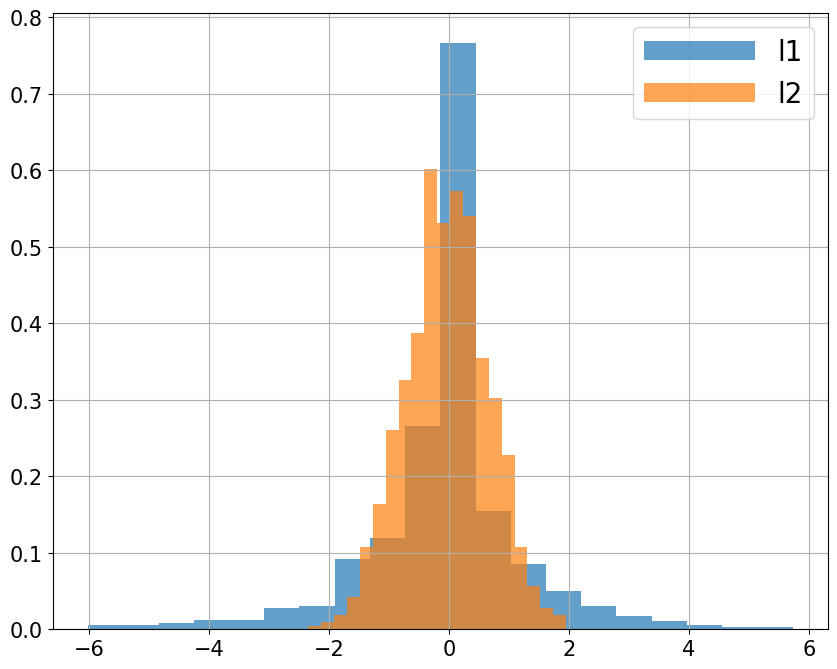

In [12]:
plt.figure(figsize=(10, 8))
plt.hist(A@x_l1-b, bins=20, label="l1", density=True, alpha=0.7)
plt.hist(A@x_l2-b, bins=20, label="l2", density=True, alpha=0.7)
plt.legend()
plt.grid()

## Эксперимент: LASSO
LASSO (Least Absolute Shrinkage and Selection Operator):

$$
\min_x \frac{1}{2}\| Ax-b \|_2^2 + \lambda \| x \|_1
$$  

In [92]:
def lasso_func(x, A, b, reg_param):
    return 1/2 * np.linalg.norm(A @ x - b)**2/A.shape[0] + reg_param * np.abs(x).sum()

def lasso_subgrad_f(x, A, b, reg_param):
    return A.T @ (A @ x - b)/A.shape[0] + reg_param * np.sign(x)

Протестируем ещё другие вариации убывающего шага:

$$
\alpha(k) = \max\left(3^{-\left\lfloor\frac{k}{50}\right\rfloor}, 10^{-5}\right) \times 0.5
$$

Данный шаг убывает каждые 50 шаго, а не каждую итерацию.

In [98]:
def alpha_function1(k):
    return max(3**(-k//50), 1e-5)*0.5

$$
\alpha(k) = \min \{ \frac{1}{\sqrt{k+1}}, 10^{-1} \}
$$

Данный шаг полезен тем, что "срезает" первые слишком большие шаги убывающего шага.

In [99]:
def alpha_function2(k):
    return min(1 / (k+1)**(0.5), 1e-1)

In [100]:
np.random.seed(1)
n = 500
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.zeros(n)
reg_param = 1e-1
epsilon = 1e-6
max_iter = 1000

In [ ]:
f = lambda x: lasso_func(x, A, b, reg_param)
subgradf = lambda x: lasso_subgrad_f(x, A, b, reg_param)

methods = [
    GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="GD, custom 1"),
    GradientDescent(SeqStepSize(alpha_function=alpha_function2), name="GD, custom 2"),
    GradientDescent(ScaledConstantStepSize(1), name="Нормированный"),
    GradientDescent(SeqStepSize(d=0.5, alpha0=1), name="Убывающий"),
]

for method in methods:
    x = method.solve(x0, f, subgradf, tol=epsilon, max_iter=max_iter)
    print(method.name, f(x))

GD, custom 1 7.703030039476224
GD, custom 2 7.403539419438873
Нормированный 8.084630307097642
Убывающий 7.411111946789489


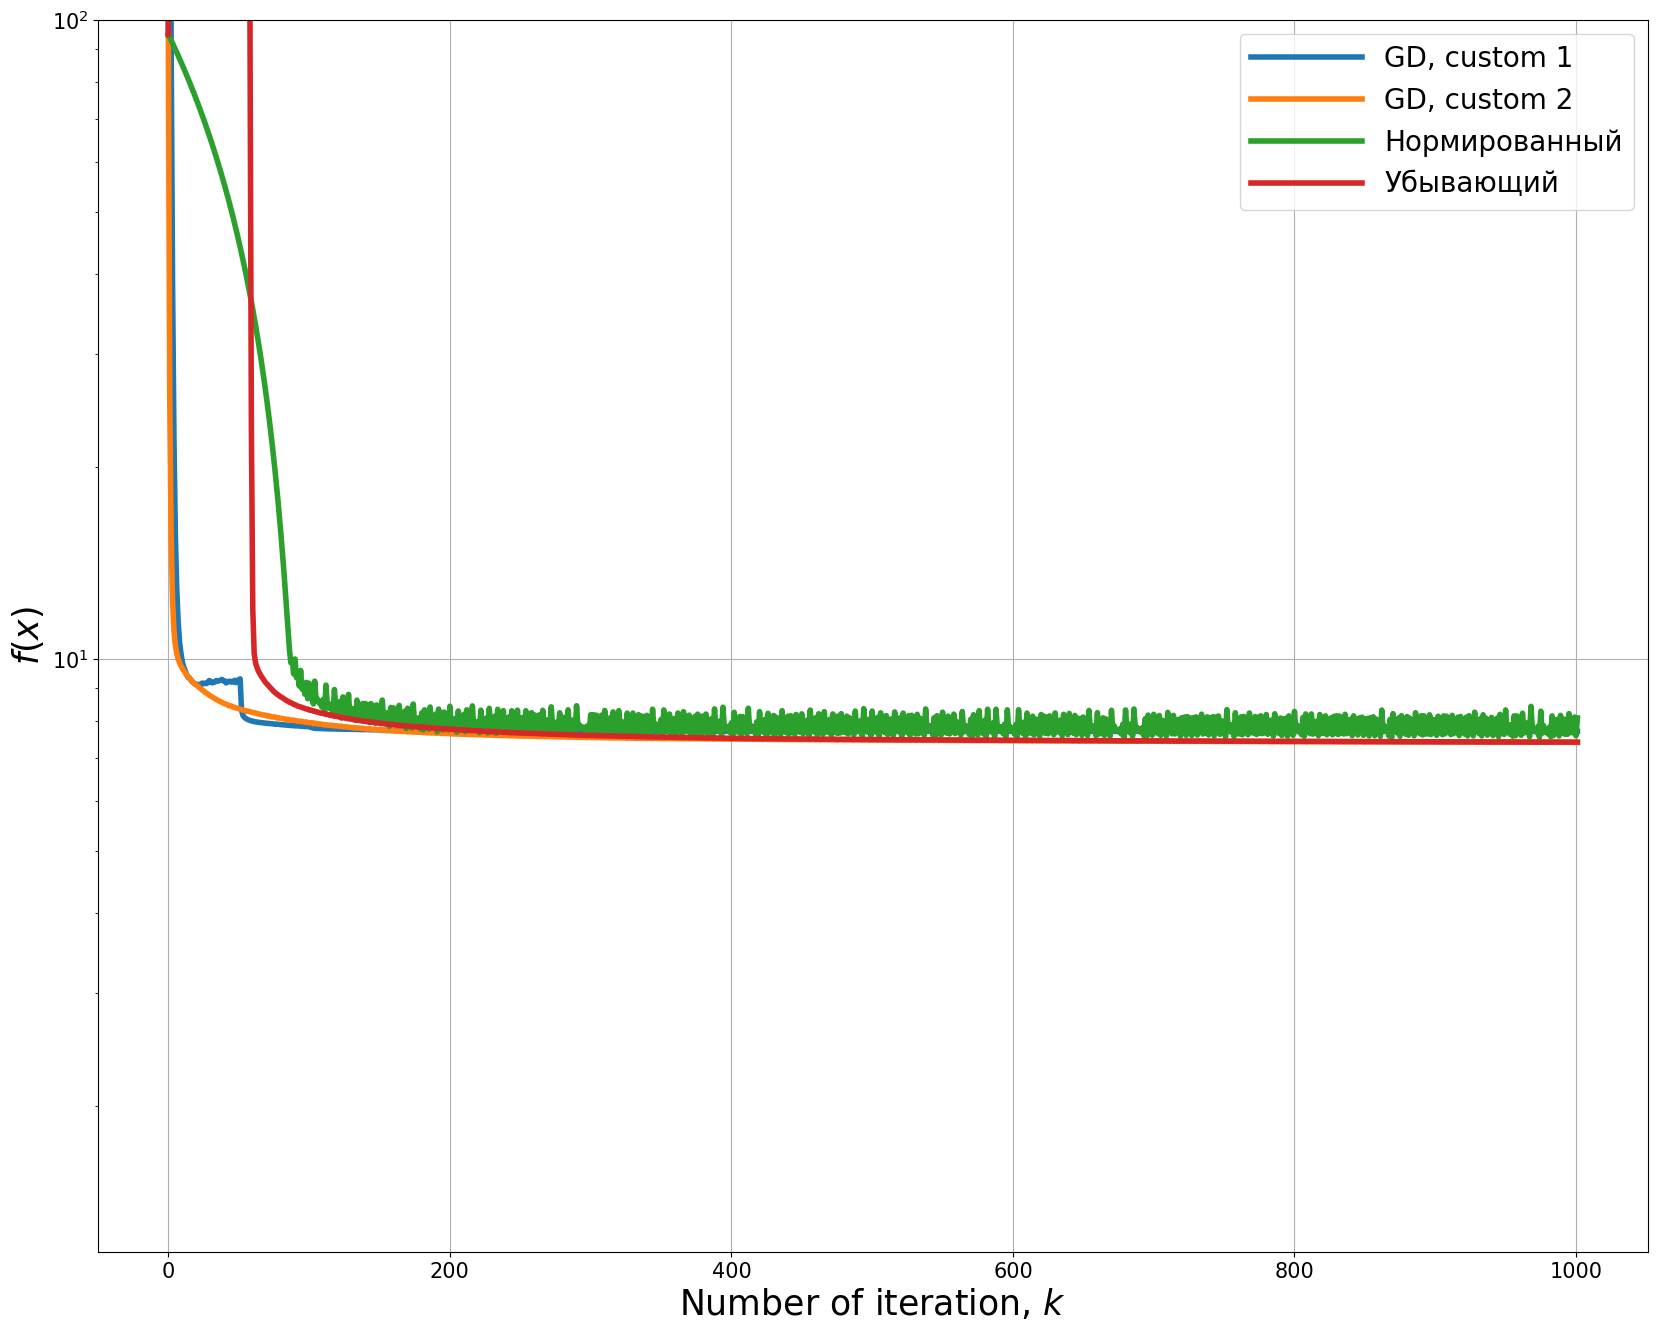

In [102]:
plt.figure(figsize=(20, 16))
funcx = lambda x: f(x)

for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)

plt.grid()
plt.ylabel(r"$f(x)$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.ylim(None, 1e+2)
plt.show()